In [107]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
This script creates an array containing energy in kWh
for a certain PV size based on ERA5-land data in a single coordinate

Created on Monday July  29 14:17:50 2019

@author: luis@refuel
"""

import xarray as xr
import pvlib
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import pvlib
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import matplotlib.pyplot as plt

#define the data sets that are going to be used
input_era5l_data = "/home/lramirez/my-data/ERA5_land_data/derived/era5l_2001_01_"



The first step is to transform the cumulated values in J/sqm to instantaneous radiation values in W/sqm

In [108]:
era5 = xr.open_dataset(input_era5l_data, chunks={'lon': 10, 'lat':10})

In [109]:
#check the data description
print(era5)

<xarray.Dataset>
Dimensions:  (lat: 1801, lon: 3600, time: 743)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01T01:00:00 ... 2001-01-31T23:00:00
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.5 359.6 359.7 359.8 359.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
Data variables:
    var167   (time, lat, lon) float32 dask.array<shape=(743, 1801, 3600), chunksize=(743, 10, 10)>
    var243   (time, lat, lon) float32 dask.array<shape=(743, 1801, 3600), chunksize=(743, 10, 10)>
    var169   (time, lat, lon) float32 dask.array<shape=(743, 1801, 3600), chunksize=(743, 10, 10)>
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Mon Aug 05 10:32:56 2019: cdo -f nc4 -copy original/adaptor...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...


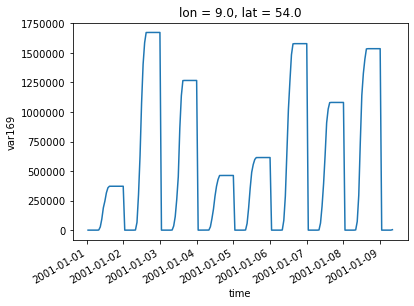

In [110]:
#167 is the temperature, 169 the ssrd and 243 the albedo
#make an example time line of the original radiation data
era5.var169[0:200,360,90].plot()

In [149]:
GHI_in_j = era5.var169[0:48,360,90].diff("time", 1, label="upper")
#print(GHI_in_j)
ghi_era5l = (GHI_in_j.where(GHI_in_j > 0, 0))/3600

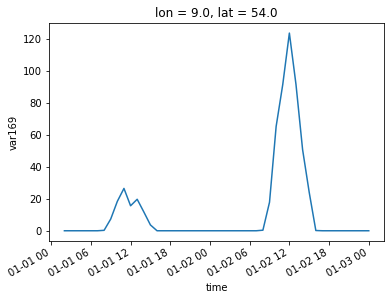

In [150]:
#(era5.var169[0:48,360,90]).plot()
ghi_era5l.plot()

Calculate the DHI and DNI from GHI using the ERBS algorithm

In [255]:
timepre = ghi_era5l["time"].values
timeindex = pd.to_datetime(timepre, dayfirst=True, utc=True, infer_datetime_format=True)
dayofyear = ghi_era5l.time.dt.dayofyear.values
Zenith = pvlib.solarposition.get_solarposition(timepre, latitude=54.0, longitude=9.0).zenith.values
#plt.plot(Zenith)
erbs = pvlib.irradiance.erbs(ghi_era5l, zenith=Zenith, datetime_or_doy=dayofyear)
dni_era5l = erbs["dni"]
dhi_era5l = erbs["dhi"]

['2001-01-01T02:00:00.000000000' '2001-01-01T03:00:00.000000000'
 '2001-01-01T04:00:00.000000000' '2001-01-01T05:00:00.000000000'
 '2001-01-01T06:00:00.000000000' '2001-01-01T07:00:00.000000000'
 '2001-01-01T08:00:00.000000000' '2001-01-01T09:00:00.000000000'
 '2001-01-01T10:00:00.000000000' '2001-01-01T11:00:00.000000000'
 '2001-01-01T12:00:00.000000000' '2001-01-01T13:00:00.000000000'
 '2001-01-01T14:00:00.000000000' '2001-01-01T15:00:00.000000000'
 '2001-01-01T16:00:00.000000000' '2001-01-01T17:00:00.000000000'
 '2001-01-01T18:00:00.000000000' '2001-01-01T19:00:00.000000000'
 '2001-01-01T20:00:00.000000000' '2001-01-01T21:00:00.000000000'
 '2001-01-01T22:00:00.000000000' '2001-01-01T23:00:00.000000000'
 '2001-01-02T00:00:00.000000000' '2001-01-02T01:00:00.000000000'
 '2001-01-02T02:00:00.000000000' '2001-01-02T03:00:00.000000000'
 '2001-01-02T04:00:00.000000000' '2001-01-02T05:00:00.000000000'
 '2001-01-02T06:00:00.000000000' '2001-01-02T07:00:00.000000000'
 '2001-01-02T08:00:00.000

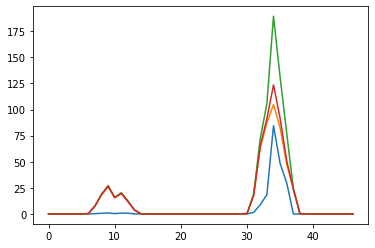

In [256]:
plt.plot(dni_era5l)
plt.plot(dhi_era5l)
plt.plot(dni_era5l+dhi_era5l)
plt.plot(ghi_era5l)
print(timeindex.values)

load Specifications from standard/declared modules and inversters

In [155]:
import gc
gc.collect()

4708

In [156]:
# load the module and inverter specifications
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

sandia_module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']

cec_inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_']

define the location and the system parameters

In [227]:
location = Location(latitude=54.0, longitude=9.0)

system = PVSystem(surface_tilt=20, surface_azimuth=2,
                  module_parameters=sandia_module,
                  inverter_parameters=cec_inverter)

mc = ModelChain(system, location)

47


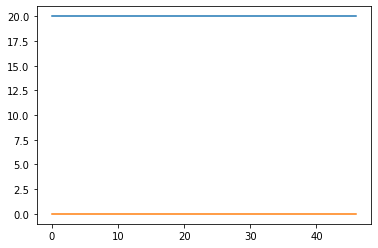

In [228]:
temperature = ((ghi_era5l.values*0)+20)
wind_speed = (ghi_era5l.values*0)
plt.plot(temperature)
plt.plot(wind_speed)
print(wind_speed.size)

In [229]:
print(mc)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temp_model: sapm_temp
  losses_model: no_extra_losses


##to do -> modify the example escript changing the time step by a time series defined by the input era5 array

2001-01-01 02:00:00+00:00    -0.020000
2001-01-01 03:00:00+00:00    -0.020000
2001-01-01 04:00:00+00:00    -0.020000
2001-01-01 05:00:00+00:00    -0.020000
2001-01-01 06:00:00+00:00    -0.020000
2001-01-01 07:00:00+00:00    -0.020000
2001-01-01 08:00:00+00:00    -0.020000
2001-01-01 09:00:00+00:00    -0.020000
2001-01-01 10:00:00+00:00     0.910435
2001-01-01 11:00:00+00:00     2.377073
2001-01-01 12:00:00+00:00     0.430263
2001-01-01 13:00:00+00:00     1.140398
2001-01-01 14:00:00+00:00    -0.020000
2001-01-01 15:00:00+00:00    -0.020000
2001-01-01 16:00:00+00:00    -0.020000
2001-01-01 17:00:00+00:00    -0.020000
2001-01-01 18:00:00+00:00    -0.020000
2001-01-01 19:00:00+00:00    -0.020000
2001-01-01 20:00:00+00:00    -0.020000
2001-01-01 21:00:00+00:00    -0.020000
2001-01-01 22:00:00+00:00    -0.020000
2001-01-01 23:00:00+00:00    -0.020000
2001-01-02 00:00:00+00:00    -0.020000
2001-01-02 01:00:00+00:00    -0.020000
2001-01-02 02:00:00+00:00    -0.020000
2001-01-02 03:00:00+00:00

/home/lramirez/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


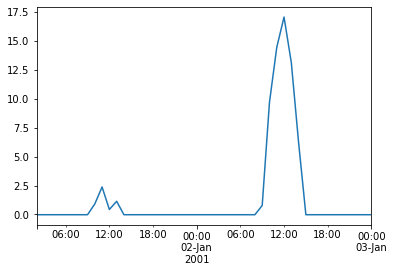

In [285]:
weather = pd.DataFrame({'ghi': ghi_era5l.values, 
                        'dni': dni_era5l, 
                        'dhi': dhi_era5l, 
                        'temp_air': temperature, 
                        'wind_speed': wind_speed},
                       index=timeindex)
weather

mc.run_model(times=weather.index, weather=weather)
print(mc.ac)
mc.ac.plot()
#for the outputs have a look of https://pvlib-python.readthedocs.io/en/latest/modelchain.html

In [ ]:
#to dos:
#integrate the temperature data!
#check the calculation also using fdir 228021 =DNI
#find the PV and inversors data bases
#make a function out of it


#further notes:
#separate the ssrd into direct and diffuse radiation 
 


    temp_air = temp_var-273.15 #rea6 temp and conversion to celsius



#slope of the PV (0-90)
slope = 70
#aspect of the PV (starting in the North)
aspect = 180
lats = 50.0
lons = 5.0
area = 4.8 #area of pv panel, 4.8 sqm for aroung 1 kWp considering an efficiency of 21%
